# Repressilator: Synthetic biological oscillator

This example shows how the [Repressilator model](pints.readthedocs.io/en/latest/toy/repressilator_model.html) can be used.

The model, formulated as an ODE, has 6 state variables: 3 mRNA concentrations and 3 protein concentrations. Only the mRNA concentrations are visible. In the example below we'll call the three outputs `m-lacI`, `m-tetR`, and `m-cl`.

The model has 4 parameters, `alpha_0`, `alpha`, `beta`, and `n`.

For an analysis using ABC, see [Toni et al.](http://rsif.royalsocietypublishing.org/content/6/31/187.short).


Parameters:
[   1 1000    5    2]


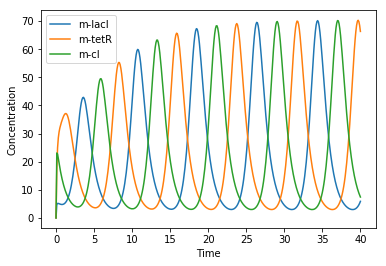

In [1]:
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create a model
model = pints.toy.RepressilatorModel()

# Run a simulation
parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(parameters, times)

print('Parameters:')
print(parameters)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)
plt.legend(['m-lacI', 'm-tetR', 'm-cl'])
plt.show()

With these parameters, the model creates wide AP waveforms that are more reminiscent of muscle cells than neurons.

We now set up a simple optimisation problem with the model.

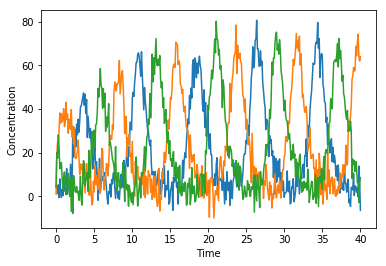

In [2]:
# First add some noise
sigma = 5
noisy = values + np.random.normal(0, sigma, values.shape)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, noisy)
plt.show()

Next, we set up a problem. Because this model has three outputs, we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [3]:
problem = pints.MultiOutputProblem(model, times, noisy)
loglikelihood = pints.KnownNoiseLogLikelihood(problem, sigma)

Now we're ready to try some inference, for example MCMC:

In [4]:
# Initial guesses
x0 = [
    [2, 800, 3, 3],
    [1, 1200, 6, 1],
    [3, 2000, 1, 4],
]

mcmc = pints.MCMCSampling(loglikelihood, 3, x0)
mcmc.set_log_to_screen(False)
mcmc.set_max_iterations(6000)
chains = mcmc.run()

/home/scratch/pints-dev/examples/pints/toy/_repressilator_model.py:94: RuntimeWarning: invalid value encountered in double_scalars
  dy[2] = -y[2] + alpha / (1 + y[4]**n) + alpha_0
/home/scratch/pints-dev/examples/pints/toy/_repressilator_model.py:92: RuntimeWarning: invalid value encountered in double_scalars
  dy[0] = -y[0] + alpha / (1 + y[5]**n) + alpha_0
/home/scratch/pints-dev/examples/pints/toy/_repressilator_model.py:93: RuntimeWarning: invalid value encountered in double_scalars
  dy[1] = -y[1] + alpha / (1 + y[3]**n) + alpha_0
/home/scratch/pints-dev/examples/pints/_mcmc/_adaptive_covariance.py:65: RuntimeWarning: covariance is not positive-semidefinite.
  self._current, np.exp(self._loga) * self._sigma)


We can use the trace plot to see if it looks like the chains have converged:

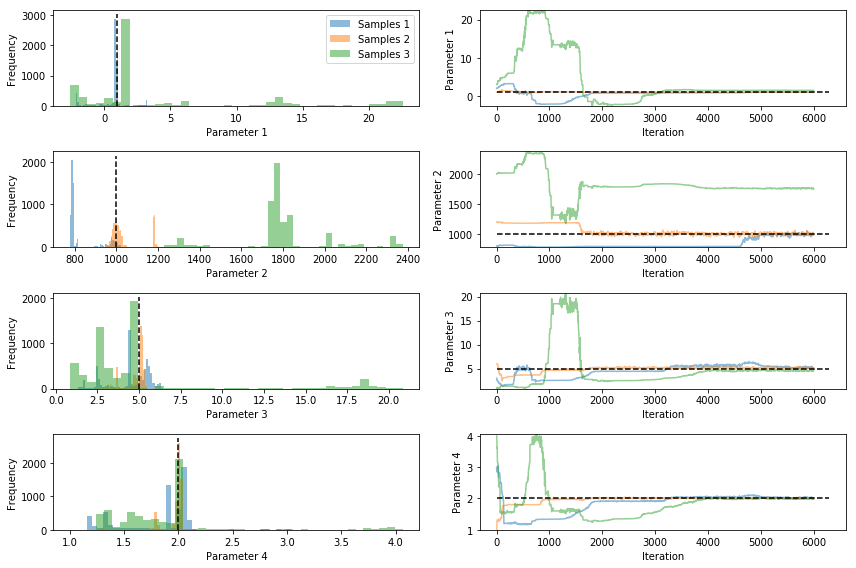

In [5]:
plt.figure()
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

So it seems MCMC gets there in the end!

We can use the final 1000 samples to look at the predicted plots:

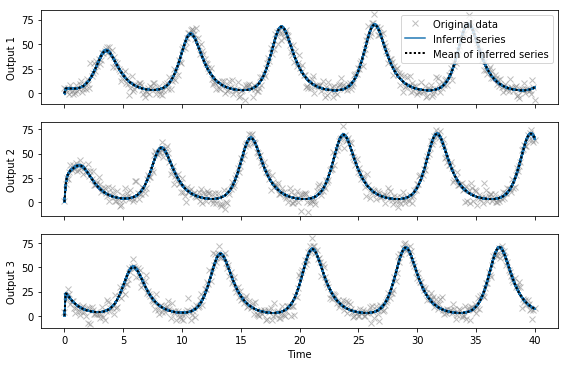

In [6]:
samples = chains[1][-1000:]

plt.figure(figsize=(12, 6))
pints.plot.series(samples, problem)
plt.show()